In this notebook I want to take an image, break it into regions, and tile it with the maximum color from that region. It is an experiment in computational photography!

In [6]:
using Colors, Images, TestImages;

The one thing I find hard to get used to with Julia is that I don't need to explicitly call functions on module names, like in Python. Just a small detail, but I'll get used to it.

In [8]:
img = testimage("lighthouse");

Here's some documentation about Arrays, which are what images are represented as: http://docs.julialang.org/en/stable/manual/arrays/

In [11]:
# find the size of the image
println(size(img))
summary(img)

(512,768)


"512×768 Array{RGB{N0f8},2}"

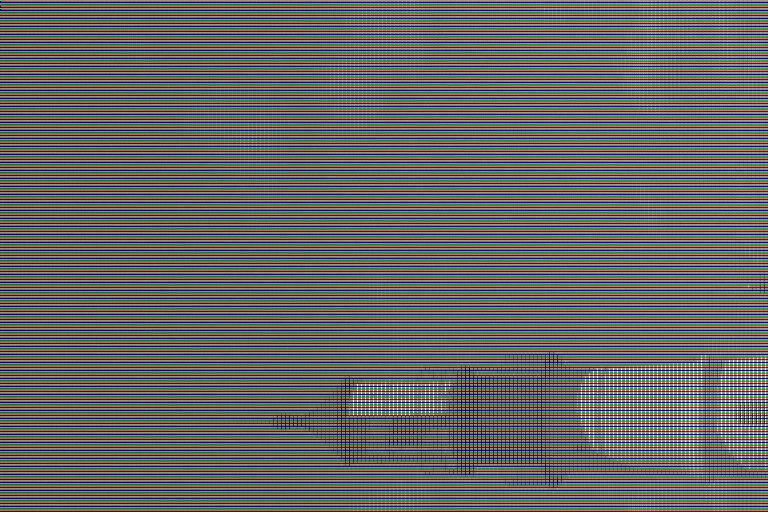

In [12]:
# create a random dense array the same size as the image
# it gets initialized with random numbers, which makes a really cool pattern!
tiled_img = Array{RGB{N0f8}, 2}(size(img))

Another way you can initialize an array like another:

In [13]:
tiled_img = similar(img);

Like in IPython, you can add a "?" at the end of a function. In Julia, you put the question mark at the start of a function.

In [114]:
?linspace

search: linspace LinSpace



```
linspace(start, stop, n=50)
```

Construct a range of `n` linearly spaced elements from `start` to `stop`.

```
linspace(c1::Color, c2::Color, n=100)
```

Generates `n`>2 colors in a linearly interpolated ramp from `c1` to`c2`, inclusive, returning an `Array` of colors.


# Iterating and Generating

There are many ways of generating a range of integers (that I will use to index into the image)

In [29]:
linspace(1, size(img, 1), 8)

8-element LinSpace{Float64}:
 1.0,74.0,147.0,220.0,293.0,366.0,439.0,512.0

In [44]:
Int16.(linspace(1, size(img, 1), 8))

8-element Array{Int16,1}:
   1
  74
 147
 220
 293
 366
 439
 512

In [42]:
Int16[i for i in linspace(1, size(img, 1), 8)]

8-element Array{Int16,1}:
   1
  74
 147
 220
 293
 366
 439
 512

You can generate x, y tile indices with an interator-like thing or a generator-like thing.

In [52]:
# or to directly generate ints
1:8:size(img, 1)

1:8:505

In [54]:
typeof(1:8:size(img, 1))

StepRange{Int64,Int64}

And the visualizations for strips of images is awesome!

In [56]:
img[1:8:size(img, 1)]

If you use these generators to index in both directions, what it basically does is tile the image and downsample.

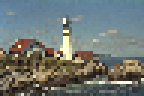

In [62]:
stepsize = 16;
img[1:stepsize:size(img, 1), 1:stepsize:size(img, 2)]

In [81]:
maximum(green.(img[1:10]))

0.518N0f8

In [83]:
maximum(green.(img[1:16, 1:16]))

0.533N0f8

And now let's put it all together to take the max R, G, and B values in a block.

In [99]:
for x in 1:stepsize:size(img, 1)
    for y in 1:stepsize:size(img, 2)
        x_end = min(x + stepsize, size(img, 1));
        y_end = min(y + stepsize, size(img, 2));
        # the @view takes a view into the image rather than making a copy
        imgv = @view img[x:x_end, y:y_end]
        tiled_img[x:x_end, y:y_end] = RGB{N0f8}(
            maximum(red.(imgv)), maximum(green.(imgv)), maximum(blue.(imgv)));
    end
end

And we can concatenate the images to put them size by side.

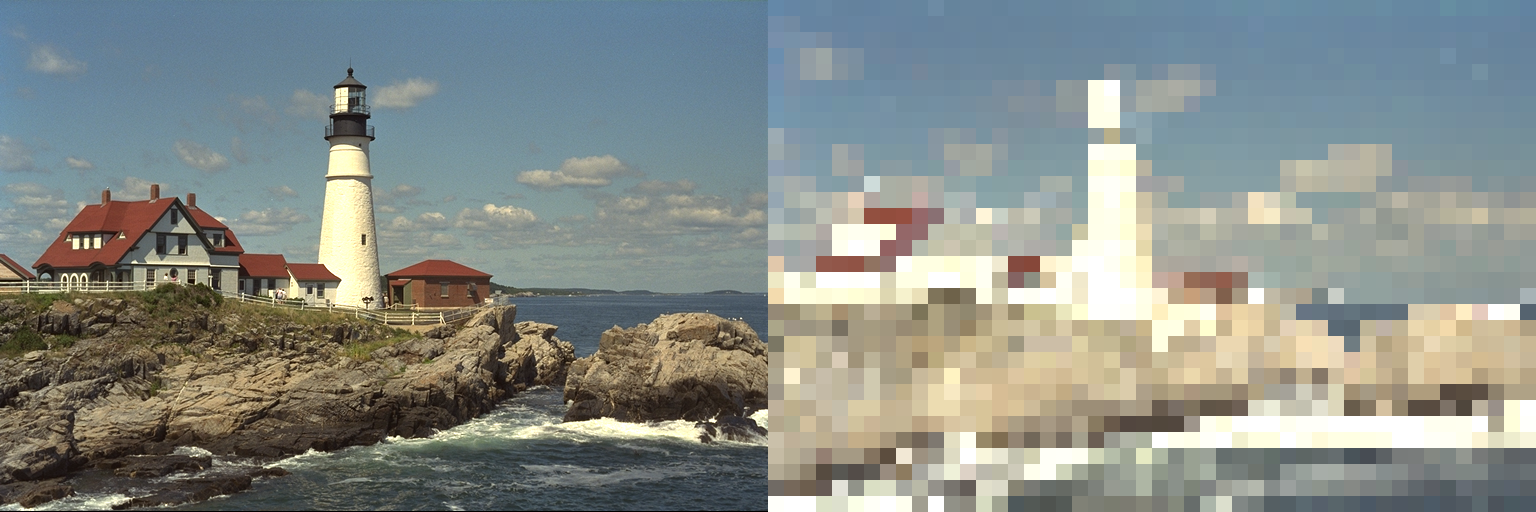

In [102]:
[img tiled_img]

I can even put all this into a function to call separately. Small notes about functions:

* Arguments can either be positional or keyword, but not both. The function below means I have to call `stepsize=` every time I want to pass `stepsize`.
* The last statement is the object returned by the function.

In [103]:
function max_tiling(img; stepsize=16)
    tiled_img = similar(img);
    for x in 1:stepsize:size(img, 1)
        for y in 1:stepsize:size(img, 2)
            x_end = min(x + stepsize, size(img, 1));
            y_end = min(y + stepsize, size(img, 2));
            imgv = @view img[x:x_end, y:y_end];
            tiled_img[x:x_end, y:y_end] = RGB{N0f8}(
                maximum(red.(imgv)), maximum(green.(imgv)), maximum(blue.(imgv)));
        end
    end
    tiled_img
end

max_tiling (generic function with 1 method)

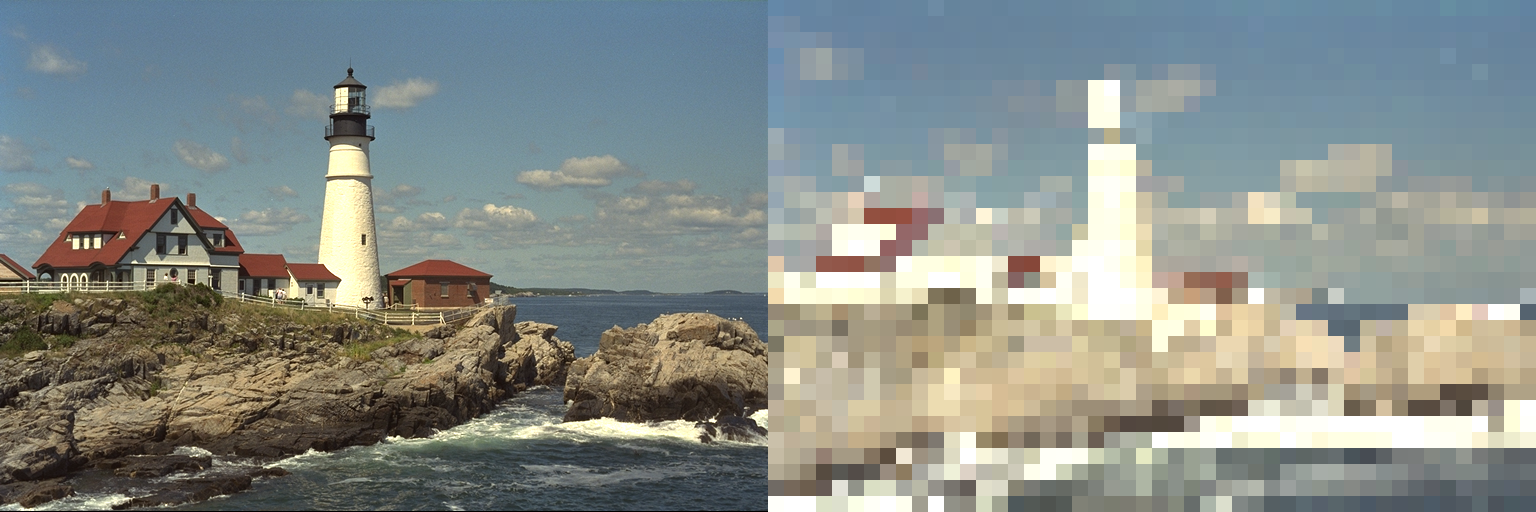

In [104]:
[img max_tiling(img, stepsize=16)]

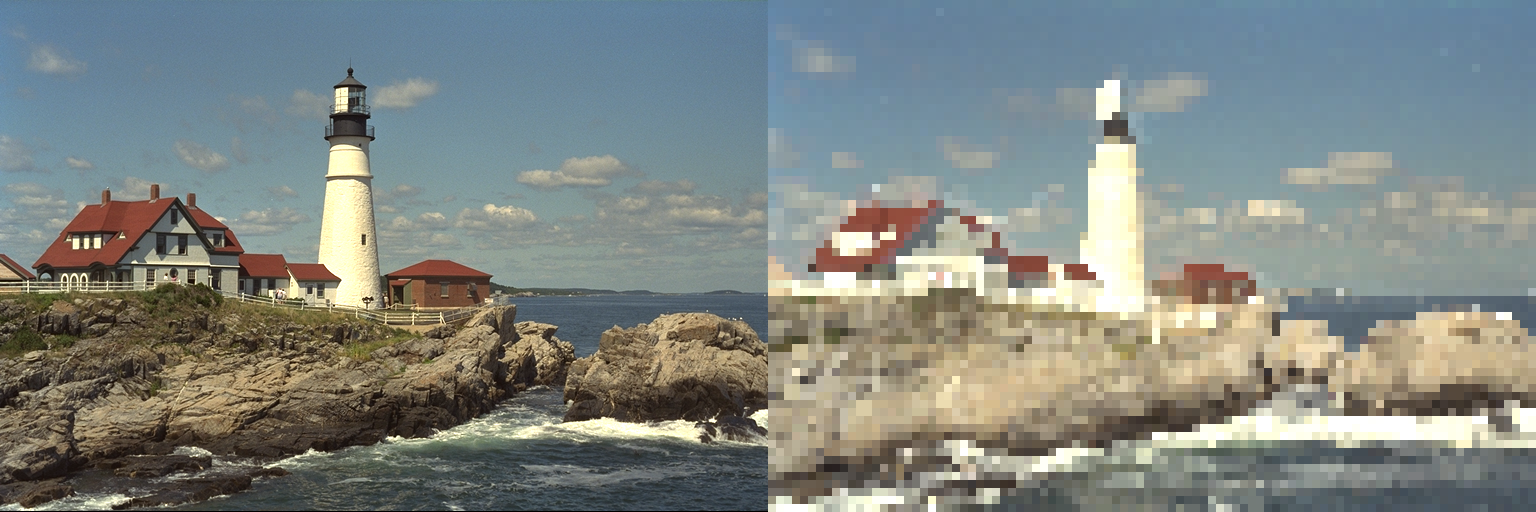

In [105]:
[img max_tiling(img, stepsize=8)]

I am told that the `interact.jl` package (https://github.com/JuliaGizmos/Interact.jl) can let me make a slider to change the stepsize!

In [106]:
for x in 1:stepsize:size(img, 1)
    for y in 1:stepsize:size(img, 2)
        x_end = min(x + stepsize, size(img, 1));
        y_end = min(y + stepsize, size(img, 2));
        imgv = @view img[x:x_end, y:y_end]
        tiled_img[x:x_end, y:y_end] = RGB{N0f8}(maximum(red.(imgv)), maximum(green.(imgv)), maximum(blue.(imgv)));
    end
end

INFO: Cloning cache of Interact from https://github.com/JuliaGizmos/Interact.jl.git
INFO: Cloning cache of Reactive from https://github.com/JuliaGizmos/Reactive.jl.git
INFO: Installing Interact v0.4.3
INFO: Installing Reactive v0.3.7
INFO: Building Interact
INFO: Enabling widgetsnbextension
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
INFO: ipywidgets version found: 5.2.2
INFO: A compatible version of ipywidgets was found. All good.
INFO: Package database updated
INFO: METADATA is out-of-date — you may not have the latest version of Interact
INFO: Use `Pkg.update()` to get the latest versions of your packages


In [112]:
# Pkg.add("Interact")

In [113]:
using Interact;

The widget lets me manipulate the step size and re-generate images directly in the notebook! Highly recommend this package =)

Interact.Options{:ToggleButtons,Int64}(Signal{Int64}(1, nactions=1),"s",1,"1",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"4"=>4,"8"=>8,"16"=>16,"32"=>32,"64"=>64),Dict(4=>"4",32=>"32",2=>"2",16=>"16",64=>"64",8=>"8",1=>"1")),Any[],Any[],true,"horizontal")

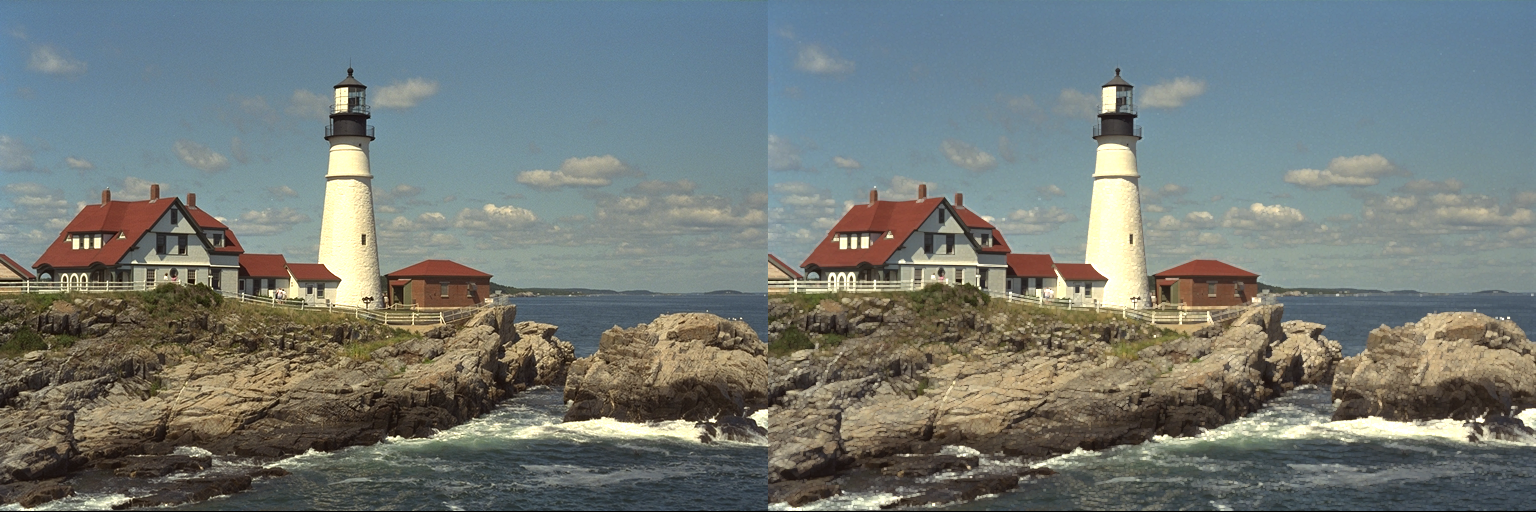

In [111]:
@manipulate for s=[2^x for x in 0:6]
    [img max_tiling(img, stepsize=s)]
end